# SDSS_PS1_DR2_stellar_offsets

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Update the job done  in `../code/AC_SDSS-PS1_offsets.ipynb`, by querying for the 48250 stars that we have CRTS lcs for, and 50000 more, to improve stats. Set search radius to 2 asec., as earlier .   Before, as in `AC_SDSS-PS1`, queries were made against PS1 DR1, and it is known that there were problems with that photometry. So to be consistent, it is good to repeat that work with DR2 ( especially that I have queries that work well ) 

First,  stripe82calibStars_v2.6.dat  catalog is 1 mln+ stars. For 10% of (that is 100 000 stars), Branimir Sesar provided CRTS light curves.  Of these, only 48250 had observations over 10 separate days (i.e. 10 day-averaged epochs). These are the 48250 stars below: 

In [42]:
address = '../../CRTS_PROJECT/data_products/CRTS_SDSS_combined_stars_catalog.dat'
sdss_crts = Table.read(address, format='ascii')
#crts_stars[['CRTS_name','ra_sdss','dec_sdss']].
#            write('sdss_s82_48250_std_stars_name_radec.txt', 
#            format='ascii', overwrite='True')

In [13]:
sdss_crts[:4][['CRTS_name','ra_sdss', 'dec_sdss']]

CRTS_name,ra_sdss,dec_sdss
int64,float64,float64
251,0.040063,0.55537
340,0.054511,-1.1499029
425,0.073721,0.404988
455,0.078358,0.235094


I use them to compare to the data I had before , and check if there are  any systematic changes.  

I add to the query list 52000 other random stars from `stripe82calibStars_v2.6.dat`  to bump it up to 100 000 stars : 

In [37]:
address = '../../CRTS_PROJECT/catalogs_SDSS/stripe82calibStars_v2.6.dat'
s82 = Table.read(address, format='ascii', 
             names = ['col1', 'RA','Dec','RArms','Decrms','Ntot','Ar', 
            'uNobs','umed', 'ummu', 'umsig', 'umrms', 'umchi2',
            'gNobs','gmed', 'gmmu', 'gmsig', 'gmrms', 'gmchi2',
            'rNobs','rmed', 'rmmu', 'rmsig', 'rmrms', 'rmchi2',
            'iNobs','imed', 'immu', 'imsig', 'imrms', 'imchi2',
            'zNobs','zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2']
            )

In [38]:
s82['starID'] = np.arange(len(s82))

In [45]:
# find out which ones are already in the CRTS list above ...
s82_coords = SkyCoord(ra=s82['RA'].data*u.degree, 
                     dec= s82['Dec'].data*u.degree)
sdss_crts_coords = SkyCoord(ra=sdss_crts['ra_sdss'].data*u.degree, 
                           dec=sdss_crts['dec_sdss'].data*u.degree)

# match SDSS-CRTS to S82 , because SDSS-CRTS has 48250 rows, and S82 catalog 1 mln + 
idx, sep2d, dist3d = sdss_crts_coords.match_to_catalog_sky(s82_coords) 

sdss_crts['d2d']=sep2d.value*3600
s82_sub1 = hstack([sdss_crts[['d2d']], s82[idx] ])

In [48]:
# now choose some more random stars from the stripe82calibStars   to complement to 
# 100k...

# choose the s82 stars that are not already in the list ... 
mask = ~np.in1d(s82['starID'].data, s82_sub1['starID'].data, )

# choose at random indices to the shorter array 
x= len(s82[mask]) 
indices = np.random.choice(a = np.arange(x), 
                           size = int(1e5 - len(crts_stars)), 
                           replace=False)
s82_sub2 = s82[mask][indices].copy()

In [49]:
s82_sub1

d2d,col1,RA,Dec,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2,starID
float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
0.0,CALIBSTARS,0.040063,0.55537,0.038,0.031,9,0.068,9,19.069,19.062,0.009,0.047,2.0,9,18.253,18.251,0.007,0.016,0.6,9,17.919,17.919,0.006,0.014,0.6,9,17.788,17.79,0.006,0.01,0.2,9,17.731,17.734,0.008,0.02,0.7,682664
0.0,CALIBSTARS,0.054511,-1.1499029,0.049,0.067,9,0.097,9,17.772,17.77,0.007,0.018,0.7,9,16.012,16.01,0.006,0.014,0.5,9,15.319,15.318,0.006,0.01,0.3,9,15.056,15.057,0.005,0.013,0.5,9,14.938,14.942,0.006,0.016,0.9,683559
0.0,CALIBSTARS,0.073721,0.404988,0.058,0.057,14,0.071,2,22.361,22.358,0.181,0.127,0.2,13,19.855,19.857,0.007,0.033,1.6,13,18.325,18.322,0.005,0.024,1.0,13,17.166,17.171,0.004,0.016,1.1,13,16.54,16.543,0.005,0.024,1.2,685679
0.0,CALIBSTARS,0.078358,0.235094,0.032,0.036,13,0.085,0,-0.33,-0.33,0.0,0.0,0.0,12,20.936,20.937,0.011,0.03,0.5,12,19.601,19.602,0.007,0.033,1.8,12,18.961,18.971,0.006,0.023,1.6,12,18.615,18.601,0.013,0.066,2.1,685700
0.0,CALIBSTARS,0.093134,0.751608,0.032,0.021,5,0.077,5,16.393,16.385,0.007,0.028,1.8,5,15.192,15.192,0.006,0.005,0.1,5,14.798,14.808,0.008,0.03,2.8,5,14.667,14.666,0.008,0.023,0.9,5,14.647,14.645,0.009,0.006,0.1,684502
0.0,CALIBSTARS,0.100371,1.1440089,0.044,0.034,13,0.08,10,22.084,22.054,0.08,0.251,1.1,12,20.204,20.197,0.009,0.042,2.0,12,19.206,19.204,0.006,0.023,1.1,12,18.782,18.779,0.006,0.026,1.5,12,18.541,18.537,0.011,0.041,1.0,685310
0.0,CALIBSTARS,0.100521,0.309938,0.08,0.055,12,0.078,0,-0.36,-0.36,0.0,0.0,0.0,11,22.595,22.573,0.038,0.092,0.5,11,21.211,21.209,0.017,0.07,1.3,11,20.296,20.291,0.012,0.037,0.9,11,19.736,19.755,0.031,0.113,1.2,685711
0.0,CALIBSTARS,0.110501,1.2332392,0.049,0.035,13,0.075,12,19.65,19.645,0.012,0.045,1.0,12,18.431,18.429,0.006,0.018,0.7,12,17.956,17.956,0.005,0.019,0.9,12,17.796,17.796,0.005,0.014,0.7,12,17.74,17.733,0.008,0.03,1.2,685311
0.0,CALIBSTARS,0.115436,0.686838,0.038,0.048,13,0.078,12,21.657,21.618,0.044,0.194,1.0,12,19.21,19.212,0.006,0.023,0.8,12,17.821,17.821,0.006,0.015,0.5,12,16.561,16.562,0.004,0.015,0.8,12,15.879,15.878,0.005,0.016,0.7,684523


In [23]:
#values,counts = np.unique(indices, return_counts=True)
#assert np.sum(counts>1) == 0 

In [50]:
s82_sub2

col1,RA,Dec,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2,starID
str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
CALIBSTARS,51.0955963,0.267032,0.045,0.067,11,0.572,0,-0.38,-0.38,0.0,0.0,0.0,10,23.047,22.974,0.05,0.218,2.0,10,21.481,21.473,0.02,0.048,0.6,10,20.223,20.215,0.011,0.03,0.8,10,19.482,19.479,0.023,0.056,0.5,954283
CALIBSTARS,318.3069458,-0.47152,0.021,0.041,9,0.168,0,0.483,0.483,0.0,0.0,0.0,8,22.013,22.034,0.029,0.088,1.0,8,20.649,20.649,0.013,0.045,1.2,8,19.911,19.916,0.01,0.026,0.8,8,19.5,19.487,0.023,0.088,2.2,263613
CALIBSTARS,26.5555763,-1.2106402,0.033,0.026,12,0.083,8,22.174,22.044,0.072,0.213,1.1,12,21.01,20.992,0.013,0.058,1.6,12,20.678,20.67,0.012,0.048,1.1,12,20.577,20.576,0.015,0.036,0.4,11,20.496,20.493,0.046,0.229,2.0,812655
CALIBSTARS,340.5323181,-0.942833,0.044,0.031,9,0.155,8,20.761,20.778,0.026,0.055,0.5,8,17.975,17.98,0.008,0.014,0.4,8,16.552,16.553,0.005,0.011,0.6,8,15.374,15.375,0.005,0.01,0.4,8,14.753,14.755,0.007,0.019,0.7,551871
CALIBSTARS,337.6195068,0.563581,0.051,0.047,9,0.184,0,0.166,0.166,0.0,0.0,0.0,9,21.942,21.897,0.025,0.099,1.4,9,20.497,20.493,0.012,0.025,0.6,9,18.987,18.979,0.007,0.021,0.8,9,18.161,18.16,0.01,0.027,0.7,517423
CALIBSTARS,315.0328064,-0.490498,0.038,0.03,9,0.201,0,0.462,0.462,0.0,0.0,0.0,8,21.563,21.552,0.021,0.064,1.1,8,20.281,20.275,0.01,0.021,0.5,8,19.721,19.712,0.009,0.03,1.1,8,19.394,19.397,0.022,0.084,1.6,197416
CALIBSTARS,315.3161011,0.219934,0.087,0.07,8,0.255,0,-0.354,-0.354,0.0,0.0,0.0,7,22.204,22.216,0.038,0.135,1.2,7,20.882,20.894,0.018,0.052,1.1,7,20.049,20.048,0.012,0.03,0.9,7,19.512,19.551,0.035,0.077,0.7,195992
CALIBSTARS,335.5246887,-0.755685,0.076,0.059,9,0.188,0,0.468,0.468,0.0,0.0,0.0,9,22.326,22.28,0.037,0.1,0.8,9,20.823,20.829,0.016,0.066,1.3,9,19.847,19.828,0.01,0.044,2.4,9,19.282,19.277,0.021,0.069,1.0,498714
CALIBSTARS,37.561718,-0.971091,0.032,0.029,11,0.088,10,22.038,22.075,0.064,0.161,0.6,10,21.239,21.228,0.016,0.045,0.8,10,20.923,20.916,0.013,0.047,1.3,10,20.837,20.816,0.018,0.055,1.0,9,20.842,20.782,0.066,0.262,1.3,873591


In [53]:
s82_sub = vstack([s82_sub1, s82_sub2])

In [54]:
s82_sub.write('stripe82calibStars_100k_subset.txt', format='ascii')

In [55]:
s82_sub[['starID', 'RA','Dec']].write('stripe82calibStars_100k_subset_ra_dec.txt',
                                     format='ascii')

Make the query against PS1 DR2 to find out objIds that match these stars : 

* go to http://mastweb.stsci.edu/ps1casjobs/  (suberlak , Xcd.... no shift )

* go to `Import`, upload the table above , call it `s82_100k_stars`

* go to `Query`, set context to `PS1 DR2`,  execute the following to find matching **objectIds**  in  `MeanObjectView` table  :
    
    
    SELECT d.starID, d.RA, d.Dec,
    o.objID, 
    o.raMean, o.decMean, o.raMeanErr, o.decMeanErr,
    o.qualityFlag,
        o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanPSFMagNpt,
o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanPSFMagNpt,
o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanPSFMagNpt,
o.zMeanPSFMag, o.zMeanPSFMagErr, o.zMeanPSFMagNpt,
o.yMeanPSFMag, o.yMeanPSFMagErr, o.yMeanPSFMagNpt,
o.rMeanKronMag, o.rMeanKronMagErr,
    o.nDetections, o.ng, o.nr, o.ni, o.nz,o.ny,
    o.gFlags, o.gQfPerfect,
    o.rFlags, o.rQfPerfect,
    o.iFlags, o.iQfPerfect,
    o.zFlags, o.zQfPerfect,
    o.yFlags, o.yQfPerfect,
    soa.primaryDetection, soa.bestDetection
     INTO mydb.[s82_100k_stars_PS1_objID]
     FROM mydb.[s82_100k_stars] d
    CROSS APPLY dbo.fGetNearbyObjEq(d.RA, d.Dec, 2.0/60.0) as x
    JOIN MeanObjectView o on o.ObjID=x.ObjId
    LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
    WHERE o.nDetections>5
    AND soa.primaryDetection>0
    AND o.gQfPerfect>0.85 and o.rQfPerfect>0.85 and o.iQfPerfect>0.85 and o.zQfPerfect>0.85
    AND (o.rmeanpsfmag - o.rmeankronmag < 0.05)
    
    
* get light curves for the matching stars from  **epochal detections**  : 


    SELECT o.objID, o.raMean, o.decMean,
    d.ra, d.dec, d.raErr, d.decErr,
    d.detectID, d.obstime, d.exptime, d.airmass, d.psfflux, d.psffluxErr, d.psfQf, d.psfQfPerfect, d.psfLikelihood, d.psfChiSq, d.extNSigma, d.zp, d.apFlux, d.apFluxErr,
    d.imageID, d.filterID,
    d.sky, d.skyerr, d.infoflag, d.infoflag2, d.infoflag3,
    o.qualityFlag,
    o.nDetections, o.primaryDetection, o.bestDetection
     INTO mydb.[s82_100k_stars_PS1_det]
     FROM mydb.[s82_100k_stars_PS1_objID] o
    JOIN Detection d on d.ObjID = o.ObjID
    
* get also light curves from **forced photometry** table : 


    SELECT o.objID, o.raMean, o.decMean,
    fwm.detectID, fwm.obstime, fwm.exptime, fwm.airmass, fwm.Fpsfflux, fwm.FpsffluxErr, fwm.FpsfQf, fwm.FpsfQfPerfect, fwm.FpsfChiSq, fwm.zp, fwm.FapFlux, fwm.FapFluxErr,
    fwm.forcedWarpID, fwm.filterID,
    fwm.Fsky, fwm.Fskyerr, fwm.Finfoflag, fwm.Finfoflag2, fwm.Finfoflag3
     INTO mydb.[s82_100k_stars_PS1_fp]
     FROM mydb.[s82_100k_stars_PS1_objID] o
    JOIN ForcedWarpMeasurement fwm on fwm.ObjID = o.ObjID




Compare previous photometry that I had for the 48250 stars  from DR1 against the DR2... any systematic offsets ? 


In [7]:
# Read the CASjobs result of querying PS1 against the 48250 SDSS stars 
# xmatched against the strips82calib...
#ps1_stars = Table.read('PS1_S82_w_err.csv', format='ascii')
#ps1_stars.rename_column('ra', 'raSDSS')
#ps1_stars.rename_column('dec', 'decSDSS')

sdss_ps1_dr1 = Table.read('../code/sdss_ps1_stripe82calibStars.txt', format='ascii')

In [58]:
# I'll be able to quickly compare the mags using the results of the first query against 
# the 'MeanObjectView' talbe 

In [4]:
# read in the S82 subset of 100k stars used to query MAST to get PS1 DR2 stars 
s82_sub = Table.read('stripe82calibStars_100k_subset.txt', format='ascii')

In [5]:
# matches to 100 k list 
ps1_dr2_objid = Table.read('s82_100k_stars_PS1_objID_suberlak.csv',
                          )

In [6]:
# join on starID to stripe82calib....
s82_dr2_objid = join(s82_sub, ps1_dr2_objid, keys='starID')

In [8]:
len(sdss_ps1_dr1)

48250

In [9]:
len(s82_dr2_objid)

94389

In [12]:
sdss_ps1_dr1[:4]

ra_sdss,dec_sdss,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,d2d_arcsec,raSDSS,decSDSS,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,gMeanPSFMagErr,rMeanPSFMag,rMeanPSFMagErr,iMeanPSFMag,iMeanPSFMagErr,zMeanPSFMag,zMeanPSFMagErr,yMeanPSFMag,yMeanPSFMagErr
float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.040063,0.55537,0.038,0.031,9,0.068,9,19.069,19.062,0.009,0.047,2.0,9,18.253,18.251,0.007,0.016,0.6,9,17.919,17.919,0.006,0.014,0.6,9,17.788,17.79,0.006,0.01,0.2,9,17.731,17.734,0.008,0.02,0.7,0.0,0.040063,0.55537,108660000401136802,0.04012087,0.55527302,79,12,20,24,11,12,18.2329998016357,0.00481300009414554,17.9456996917725,0.00618899986147881,17.8281002044678,0.00433999998494983,17.7985000610352,0.00664799986407161,17.7858009338379,0.0151909999549389
0.054511,-1.1499029,0.049,0.067,9,0.097,9,17.772,17.77,0.007,0.018,0.7,9,16.012,16.01,0.006,0.014,0.5,9,15.319,15.318,0.006,0.01,0.3,9,15.056,15.057,0.005,0.013,0.5,9,14.938,14.942,0.006,0.016,0.9,0.0,0.054511,-1.1499029,106620000545480580,0.05450671,-1.14991365,91,12,26,29,10,14,15.891900062561,0.00447600008919835,15.2995004653931,0.00268899998627603,15.0699996948242,0.00328799989074469,14.9767999649048,0.00212300010025501,14.8829002380371,0.00330199999734759
0.073721,0.404988,0.058,0.057,14,0.071,2,22.361,22.358,0.181,0.127,0.2,13,19.855,19.857,0.007,0.033,1.6,13,18.325,18.322,0.005,0.024,1.0,13,17.166,17.171,0.004,0.016,1.1,13,16.54,16.543,0.005,0.024,1.2,0.0,0.073721,0.404988,108480000736626486,0.07361949,0.40507637,69,12,14,23,10,10,19.6247005462646,0.00874499976634979,18.3346996307373,0.00559799978509545,17.1863994598389,0.00393099989742041,16.6585006713867,0.00471600005403161,16.396900177002,0.00609599985182285
0.078358,0.235094,0.032,0.036,13,0.085,0,-0.33,-0.33,0.0,0.0,0.0,12,20.936,20.937,0.011,0.03,0.5,12,19.601,19.602,0.007,0.033,1.8,12,18.961,18.971,0.006,0.023,1.6,12,18.615,18.601,0.013,0.066,2.1,0.0,0.078358,0.235094,108280000783302529,0.07834744,0.23504445,82,10,22,25,12,13,20.7171001434326,0.0203070007264614,19.6212997436523,0.0103320004418492,18.9897003173828,0.00480500003322959,18.7287006378174,0.012648000381887,18.5344009399414,0.0279079992324114


In [11]:
s82_dr2_objid[:4]

d2d,col1,RA_1,Dec_1,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2,starID,RA_2,Dec_2,objID,raMean,decMean,raMeanErr,decMeanErr,qualityFlag,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagNpt,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagNpt,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagNpt,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagNpt,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagNpt,rMeanKronMag,rMeanKronMagErr,nDetections,ng,nr,ni,nz,ny,gFlags,gQfPerfect,rFlags,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection
float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,int64
--,CALIBSTARS,308.5018921,-1.1764922,0.005,0.024,4,0.559,4,20.561,20.553,0.033,0.08,1.4,4,18.479,18.461,0.009,0.017,0.7,4,17.556,17.556,0.008,0.006,0.1,4,17.197,17.205,0.011,0.024,0.3,4,16.966,16.963,0.012,0.009,0.2,3,308.5018921,-1.1764922,106583085019058650,308.50192947,-1.17649175,0.00535999983549118,0.00939999986439943,60,18.3159999847412,0.00643099984154105,13,17.535400390625,0.00442800018936396,9,17.1793994903564,0.00359200011007488,15,17.0112991333008,0.00268199993297458,4,16.8708000183105,0.0189500004053116,8,17.609899520874,0.00455200020223856,67,14,15,18,10,10,115000,0.999595999717712,115000,0.999330997467041,115000,0.999351978302002,115000,0.999548971652985,115000,0.99917197227478,1,1
0.0,CALIBSTARS,308.5130005,-1.1205829,0.012,0.026,4,0.532,4,19.059,19.066,0.015,0.057,2.5,4,17.686,17.686,0.007,0.009,0.6,4,17.105,17.104,0.004,0.01,1.0,4,16.865,16.866,0.006,0.005,0.2,4,16.726,16.728,0.01,0.009,0.2,16,308.5130005,-1.1205829,106653085129895726,308.51302297,-1.12060043,0.0190699994564056,0.0165100004523993,60,17.5977001190186,0.00656800018623471,14,17.1025009155273,0.00359299988485873,15,16.8768005371094,0.00317299994640052,17,16.7877006530762,0.00425799982622266,8,16.7164001464844,0.00490699987858534,13,17.1672992706299,0.00220400001853704,80,16,16,24,10,14,115000,0.999724984169006,115000,0.999543011188507,115000,0.999419987201691,115000,0.999665975570679,115000,0.999668002128601,1,1
0.0,CALIBSTARS,308.5223999,-1.207152,0.023,0.019,4,0.553,4,18.803,18.8,0.014,0.037,1.4,4,17.444,17.443,0.007,0.003,0.0,4,16.81,16.806,0.004,0.008,0.8,4,16.542,16.542,0.006,0.013,0.8,4,16.403,16.402,0.01,0.008,0.1,19,308.5223999,-1.207152,106553085223761829,308.5223816,-1.20719741,0.00310999993234873,0.00698000006377697,60,17.3484001159668,0.00315000000409782,12,16.808500289917,0.002779999980703,14,16.5454006195068,0.00352800008840859,20,16.4207992553711,0.00286899995990098,10,16.3568992614746,0.00697499979287386,13,16.8705005645752,0.00464599998667836,86,15,18,28,12,13,115000,0.9998379945755,115000,0.999575972557068,115000,0.99990701675415,115000,0.999334990978241,115000,0.99950897693634,1,1
--,CALIBSTARS,308.5411072,-1.1562052,0.004,0.025,4,0.531,4,17.305,17.306,0.011,0.044,2.2,4,15.654,15.657,0.006,0.013,0.5,4,14.984,14.984,0.003,0.006,0.6,4,14.714,14.71,0.006,0.003,0.1,4,14.581,14.588,0.009,0.019,1.0,30,308.5411072,-1.1562052,106613085411033004,308.54113481,-1.1561983,0.00832000002264977,0.00575000001117587,60,15.5490999221802,0.00396900018677115,10,14.9664001464844,0.00267999991774559,12,14.7228002548218,0.00423800013959408,9,14.6187000274658,0.00248900009319186,13,14.5462999343872,0.00211300002411008,12,15.0151996612549,0.000921000028029084,72,13,14,16,14,15,115000,0.99975198507309,11

Looks good - so now check how s82 r-band compares to ps1 dr2 detections r-band - ould we use it without any offset  at all ?  

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


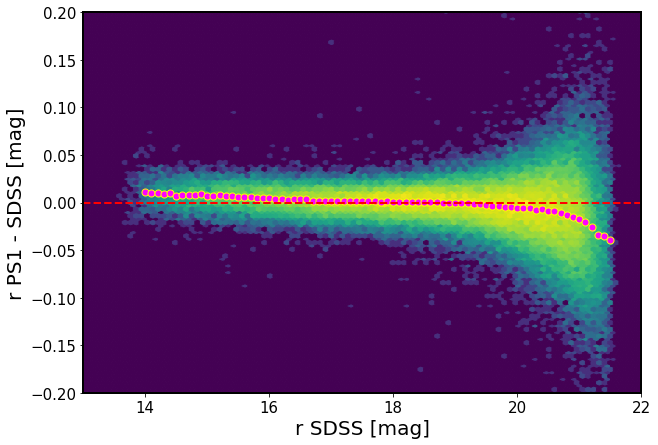

In [14]:

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(10,7))
xsdss = s82_dr2_objid['rmed']
xps1 = s82_dr2_objid['rMeanPSFMag']   
x = xsdss
y = xps1 - xsdss 
image = ax.hexbin(x,y,  extent=(13,22,-0.2,.2),
         bins='log')
# plot the medians too ..
xlim = ax.get_xlim()
min_x, max_x , step_size = 14,21.5, 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
#median_y_err = np.zeros(len(mean_x))
ylim = ax.get_ylim()
ymin, ymax = ylim[0],ylim[1]

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask1=  ((mean_x[j] - dx) < x) & (x<  (mean_x[j] + dx))
    mask2 =  (ymin<y)&(y<ymax)
    median_y[j] = np.median(y[mask1&mask2])
   #median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
ax.axhline(0, lw=2,ls='--',c='r')
ax.scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow',
          s=50)
ax.set_xlabel('r SDSS [mag]')
ax.set_ylabel('r PS1 - SDSS [mag]')
#plt.colorbarimage)
#ax.set_title('Stripe82calib ' + str(len(x)) + ' stars')
plt.savefig('PS1_DR2_detections_SDSS_Stripe82Calib.png', 
           bbox_inches='tight', dpi=100)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


[-0.00037085  0.00326623]


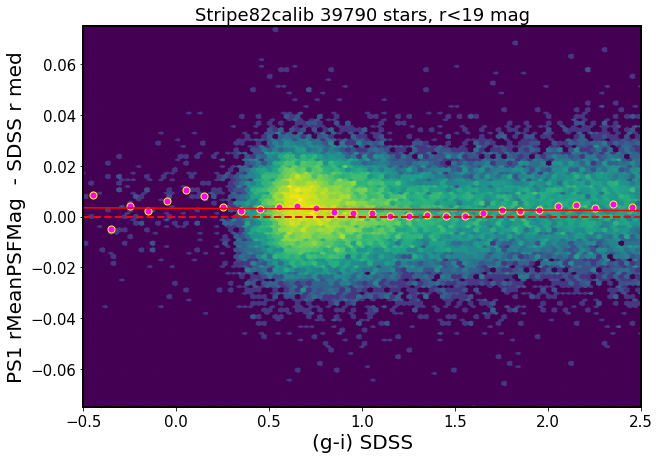

In [125]:
# plot the same against SDSS g-i  

# check how s82 r-band compares to ps1 dr2 detections r-band - 
# could we use it without any offset  at all ?  
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(10,7))

m = s82_dr2_objid['rmed'] < 19
data = s82_dr2_objid[m].copy()

x = data['gmed'].data - data['imed'].data
y = data['rMeanPSFMag'].data  - data['rmed'].data 

e1 = data['rMeanPSFMagErr'].data # PS1 error on the Mean 
e2 = data['rmsig'].data  # SDSS standard error for the mean
       
image = ax.hexbin(x,y,  extent=(-0.5,2.5,-0.075,.075),
         bins='log')
# plot the medians too ..
xlim = (-0.5,2.5)#ax.get_xlim()
min_x, max_x , step_size = -0.45,2.5, 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
#median_y_err = np.zeros(len(mean_x))
ylim = ax.get_ylim()
ymin, ymax = ylim[0],ylim[1]

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask1=  ((mean_x[j] - dx) < x) & (x<  (mean_x[j] + dx))
    mask2 =  (ymin<y)&(y<ymax)
    median_y[j] = np.median(y[mask1&mask2])
   #median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
ax.axhline(0, lw=2,ls='--',c='r')
ax.scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow',
          s=50)
ax.set_xlabel('(g-i) SDSS')
ax.set_ylabel('PS1 rMeanPSFMag  - SDSS r med')
#plt.colorbarimage)
ax.set_title('Stripe82calib ' + str(len(x)) + ' stars, r<19 mag'),

# fit first degree polynomial
# make my own linear fits 
m2 = (xlim[0]<x)*(x<xlim[1]) # within the vertical dashed lines 
m3 = (ymin < y) *(y < ymax) # within the ylims of the plot 
m_ = m2*m3
xf  = x[m_] ;  yf =y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)

#ax[i].scatter(xf,yf , s=0.01)
p = np.polyfit(xf,yf,deg=1, w=1/ef)
# y = B_0 + B_1 * x  in Tonry+2012 
x_ = np.linspace(xlim[0],xlim[1], 100)
ax.plot(x_, p[0] *x_ + p[1]  , c='red')
print(p)
ax.set_xlim(xlim)
plt.savefig('PS1_DR2_detections_SDSS_Stripe82Calib_g-i.png', 
           bbox_inches='tight', dpi=100)

In [19]:
s82_dr2_objid[:3]

d2d,col1,RA_1,Dec_1,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2,starID,RA_2,Dec_2,objID,raMean,decMean,raMeanErr,decMeanErr,qualityFlag,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagNpt,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagNpt,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagNpt,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagNpt,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagNpt,rMeanKronMag,rMeanKronMagErr,nDetections,ng,nr,ni,nz,ny,gFlags,gQfPerfect,rFlags,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection
float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,int64
--,CALIBSTARS,308.5018921,-1.1764922,0.005,0.024,4,0.559,4,20.561,20.553,0.033,0.08,1.4,4,18.479,18.461,0.009,0.017,0.7,4,17.556,17.556,0.008,0.006,0.1,4,17.197,17.205,0.011,0.024,0.3,4,16.966,16.963,0.012,0.009,0.2,3,308.5018921,-1.1764922,106583085019058650,308.50192947,-1.17649175,0.00535999983549118,0.00939999986439943,60,18.3159999847412,0.00643099984154105,13,17.535400390625,0.00442800018936396,9,17.1793994903564,0.00359200011007488,15,17.0112991333008,0.00268199993297458,4,16.8708000183105,0.0189500004053116,8,17.609899520874,0.00455200020223856,67,14,15,18,10,10,115000,0.999595999717712,115000,0.999330997467041,115000,0.999351978302002,115000,0.999548971652985,115000,0.99917197227478,1,1
0.0,CALIBSTARS,308.5130005,-1.1205829,0.012,0.026,4,0.532,4,19.059,19.066,0.015,0.057,2.5,4,17.686,17.686,0.007,0.009,0.6,4,17.105,17.104,0.004,0.01,1.0,4,16.865,16.866,0.006,0.005,0.2,4,16.726,16.728,0.01,0.009,0.2,16,308.5130005,-1.1205829,106653085129895726,308.51302297,-1.12060043,0.0190699994564056,0.0165100004523993,60,17.5977001190186,0.00656800018623471,14,17.1025009155273,0.00359299988485873,15,16.8768005371094,0.00317299994640052,17,16.7877006530762,0.00425799982622266,8,16.7164001464844,0.00490699987858534,13,17.1672992706299,0.00220400001853704,80,16,16,24,10,14,115000,0.999724984169006,115000,0.999543011188507,115000,0.999419987201691,115000,0.999665975570679,115000,0.999668002128601,1,1
0.0,CALIBSTARS,308.5223999,-1.207152,0.023,0.019,4,0.553,4,18.803,18.8,0.014,0.037,1.4,4,17.444,17.443,0.007,0.003,0.0,4,16.81,16.806,0.004,0.008,0.8,4,16.542,16.542,0.006,0.013,0.8,4,16.403,16.402,0.01,0.008,0.1,19,308.5223999,-1.207152,106553085223761829,308.5223816,-1.20719741,0.00310999993234873,0.00698000006377697,60,17.3484001159668,0.00315000000409782,12,16.808500289917,0.002779999980703,14,16.5454006195068,0.00352800008840859,20,16.4207992553711,0.00286899995990098,10,16.3568992614746,0.00697499979287386,13,16.8705005645752,0.00464599998667836,86,15,18,28,12,13,115000,0.9998379945755,115000,0.999575972557068,115000,0.99990701675415,115000,0.999334990978241,115000,0.99950897693634,1,1


Make Fig.4 (three panels) - code straight from `../code/AC_SDSS_PS1_offsets.ipynb`. 

In [24]:
# Try to combine all in one function ...
%matplotlib inline 
def photometric_offset_sdss_ps1(data, sdsscolors = 'gr', 
                                targetbands = 'grizz', originbands = 'grizy',
                                s82mag = 'mmed', s82err = 'msig',
                                cutoffmag = 19 , xlims = [-0.5,2.5],
                                correct_extinction = True, 
                                ebv_sfd = None,
                                extinction = 'SFD', nrows=2, ncols=3,
                                storeStarID = False
                               ):
    '''
    Find photometric offsets between SDSS and PS1, 
    or another survey. 
    
    data :  a table containing ugriz SDSS photometry, cross-matched to 
            the target survey, eg. SDSS-PS1
            
    sdsscolors : SDSS colors used to spread the stellar locus.  It can be 
           "gr" or "gi" (this mainly affects the x-axis limits)
           
    targetbands : SDSS bands to emulate. It can be "r" if all photometry 
           from target survey should be compared to SDSS(r), eg. 
           PS1(gri) --> SDSS(rrr),  or "grizz"  if each source band
           should be compared to an equivalent SDSS band, eg.
           PS1(grizy) --> SDSS(grizz)  (as in Tonry2012 for PS1).
           
    originbands : bands present in the origin survey. Eg, for PS1 they're 
           'grizy'
    
    cutoffmag : magnitude cutoff to ignore very faint stars according
          to SDSS target magnitude (eg. if yaxis is "grizz" then we filter
          by "grizz < cutoffmag" separately for each panel)
          
    xlims : limits on the x-axis in magnitudes (depends on the 
          SDSS color chosen for the x-axis). By default, [-0.5,2.5]
          
    correct_extinction : shall we correct for  interstellar extinction before 
          finding offsets ? If "True" , then "ebv_sfd"  needs to be provided,
          which is expected to be an array of the same length as the input SDSS 
          table ("data"). E(B-V) is selective extinction at V, or "reddening" : 
          E(B-V) = (B-V)_obs - (B-V)_true , with B,V being magnitudes in B,V. 
          Then the "total extinction" A(V) in a given filter, eg. V, is linked to 
          E(B-V) via the "extinction law"  : 
          A(V) = R(V) * E(B-V) , where R(V) is most commonly taken to be 3.1 . 
          The total extinction is expressed in magnitudes, that have to be
          subtracted from the observed magnitudes - object becomes brighter : 
          m_(V,corr) = m_(V,obs) - A(V), 
          so that the corrected distance modulus : 
          5 * log_10(d_(V,corr)) = m_(V,obs) - A(V) - M_V + 5 = 
                                 = m_(V,corr) - M_V + 5
        If correct_extinction = False , then we do not correct for extinction. 
                                 
    ebv_sfd : the table of interstellar reddening in units of Schlegel,Finkbeiner,Davis,
          which can be translated to total extinction A(b) in each band b using the 
          coefficients from Table6 in Schlegel,Finkbeiner2011, assuming RV = 3.1 .
          
    extinction : which reddening data from dustmaps  was used?  Eg. 
          "SFD"   Schlegel,Finkbeiner,Davis1998
          "Bayestar17"  
          
        # Example of obtaining SFD and Bayestar EBV_SFD using dustmaps
        # 1 : query 2D  SFD1998 map 
        import dustmaps.sfd
        dustmaps.sfd.fetch()
        from dustmaps.sfd import SFDQuery
        sfd = SFDQuery()
        coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                           sdss_ps1['dec_sdss']*units.deg,
                           frame='icrs')
        ebv_1 = sfd(coords)

        # 2 query 3D Bayestar17 map 
        import dustmaps.bayestar
        dustmaps.bayestar.fetch()
        from dustmaps.bayestar import BayestarQuery
        coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                           sdss_ps1['dec_sdss']*units.deg, 
                           distance=4*units.kpc,
                           frame='icrs')
        bayestar = BayestarQuery(max_samples=1)
        ebv_2 = bayestar(coords, mode='median')
        
        Both ebv_1  and ebv_2  would be appropriate examples of reddening 
        in SFD units. 
         
    nrows, ncols : number of rows and columns for the plot. 
        Recommended :  if originbands  = 'grizy'  (PS1) , then (nrows,ncols)=(3,2),
        if 'gri' (PS1)  --> (2,2) , 
        if 'gR' (PTF)  --> (1,2)
        if  'V' (CRTS) --> (1,1) 
    '''
    # $ Table 6 SF2011 Coefficients with RV=3.1 from EBV_SFD to A
    ebv_sfd_to_A = {'p1g':3.172, 'p1r':2.271, 'p1i':1.682, 'p1z':1.322, 'p1y':1.087,
        'sdssu':4.239, 'sdssg':3.303, 'sdssr':2.285, 'sdssi':1.698, 'sdssz': 1.263}

    # set file names ,  figure title .. 
    
    if correct_extinction : 
        #suptitle='Extinction corrected  : dustmaps ' +  extinction
        ext = 'ext-'+extinction
    else:
        #suptitle  = 'No extinction correction'
        ext = 'ext-NO'

    # extinction coefficients for SDSS Standards 
    #Cm = {'u':1.873, 'g':1.377, 'r':1.0, 'i':0.758, 'z':0.537}
    #Ar = sdss_ps1['AR_val']

    # we subtract the extinction coefficient, 
    # 'brightening' the given star
    #gmag = sdss_ps1['g_mMed'] -  Cm['g'] * Ar
    #rmag = sdss_ps1['r_mMed'] -  Cm['r'] * Ar
    #imag = sdss_ps1['i_mMed'] -  Cm['i'] * Ar  
    
    # correct SDSS photometry for extinction ... 
    if correct_extinction : 
        gmag = data['g'+s82mag] - ebv_sfd_to_A['sdssg'] * ebv_sfd
        rmag = data['r'+s82mag] - ebv_sfd_to_A['sdssr'] * ebv_sfd
        imag = data['i'+s82mag] - ebv_sfd_to_A['sdssi'] * ebv_sfd
    else:
        gmag = data['g'+s82mag] 
        rmag = data['r'+s82mag]
        imag = data['i'+s82mag] 


    # Coefficients from Schlegel,Finkbeiner2011
    #ps1_coeffs = {'g':3.172,  'r':2.271 , 'i':1.682, 
    #             'z':1.322 , 'y':1.087} 
    
    #xaxis : 'gi' or 'gr'
    if sdsscolors is 'gr': 
        x =  gmag-rmag   # SDSS (g-r)
        xQSOlims = [-0.25, 0.75]
        xFITlims = [0.1, 1.1]
    if sdsscolors is 'gi' : 
        x = gmag-imag  # SDSS (g-i)
        xQSOlims = [ -0.2, 0.8 ]
        xFITlims = [0.25, 1.5]
        

    #yaxis : 'SDSSgrizz' or 'SDSSr'
    if targetbands is 'grizz' : 
        ymin = {'g':-0.3,'r':-0.3,'i':-0.3,'z':-0.3,'y':-0.3}
        ymax = {'g':0.2,'r':0.2, 'i':0.2, 'z':0.2,   'y':0.2}
        SDSSfilters = 'grizz'
        
    if targetbands is 'r' : 
        ymax = {'g':1.5,'r':0.2, 'i':   0,'z':0,   'y':0}
        ymin = {'g':-0.2,'r':-0.2,'i':-0.6,'z':-0.8,'y':-0.8}
        SDSSfilters = len(originbands) * 'r'

    # define the plotting space 
    fig,axs = plt.subplots(nrows,ncols, figsize=(6*ncols+1,5.8*nrows))
    ax = np.ravel(axs)
    i = 0 
    
    # make a table to store coefficients derived from this set of data 
    coeffs  = {'x' : [], 'y' : [], 'B_0' : [], 'B_1':[]}
    
    for f1,f2 in zip(originbands, SDSSfilters):  
        print(' ')
        # store filters used 
        coeffs['x'].append('('+sdsscolors[0]+'-'+sdsscolors[1]+')_SDSS')
        coeffs['y'].append(f1 + '_P1-'+f2+'_SDSS)')
        
        print('Starting with ', len(data[f1+'MeanPSFMag']), 'stars in filter PS1 ', f1)
        
        # remove stars that have no PS1 obs in that filter 
        ma = data[f1+'MeanPSFMag'] > 0
        print('- Removing ', np.sum(~ma) , 
              ' objects that do not have PS1 obs in that filter')
        
        # remove faint stars to clean up the plot  : I'm sure that's 
        # what Tonry did, although not mentioned explicitly ... 
        mb = data[f2 + s82mag] < cutoffmag
        print('- Removing ', np.sum(~mb), 
              ' objects that are have SDSS ',f2, ' mag fainter  than ', cutoffmag)
        
        # apply the two criteria from the header 
        # to stripe82calibStars_v2.6.dat : 
        ###  1) To select sources with reliable photometry in the u and z bands
        ###     don't forget to require Nobs >= 4
        ###  2) to avoid a slight bias (~0.02 mag) at the faint end in the gri  
        ###     bands, require msig*sqrt(Nobs) < 0.03 
        # ---> point 2 not needed, because we are NOT USING FAINT END !!! 
        #mc = data['u_mErr'] * np.sqrt(data['u_Nobs']) < 0.03
        #print('- Removing ', np.sum(~mc), ' objects that do not fulfill ',
        #     ' mErr * sqrt(Nobs) < 0.03 criterion ')
        m1 = ma * mb #* mc 
        
        if f2 is 'u' or f2 is 'z' : 
            md = data[f2+'_Nobs']  >= 4
            print('- Removing ',np.sum(~md), 
                  ' objects that have less than 4 obs in  this band')
            m1 = ma * mb * mc * md 

        print('= Left with ', np.sum(m1), ' objects')
        
        if storeStarID : 
            # store the starID of stars used for the offset .... 
            name = 'StarID_PS1'+f1+'-SDSS'+f2+'_'+ext+'.txt'
            data[['starID', 'RA', 'Dec']][m1].write(name, format='ascii', 
                                                    overwrite=True)
            print('Stored the starIDs of all stars used for this offset as ', name )

        if correct_extinction :
        
            # Correct for extinction using 
            # Ab based on ebv_sfd from 
            # dustmaps sfdquery
            # and example on their website 
            # https://dustmaps.readthedocs.io/en/latest/examples.html
            #Av = ps1_coeffs[f1] * ebv_sfd
            #ps1mag  = sdss_ps1[f1+'MeanPSFMag'] - Av

            ps1mag = data[f1+'MeanPSFMag'] - ebv_sfd_to_A['p1'+f1]*ebv_sfd

            # correct SDSS using data from the Table of standards
            #sdssmag  = sdss_ps1[f2+'_mMed'] - Cm[f2] * Ar 
            sdssmag  = data[f2 +s82mag] - ebv_sfd_to_A['sdss'+f2]*ebv_sfd
            
        else: # use uncorrected values 
            ps1mag = data[f1+'MeanPSFMag']
            sdssmag  = data[f2 + s82mag]
            
        y  = ps1mag - sdssmag  # fPS1 - fSDSS

        # combine errors in quadrature to use as weights in 
        # fitting with polynomial 
        e1 = data[f1+'MeanPSFMagErr'] # PS1 error on the Mean 
        e2 = data[f2+s82err]  # SDSS standard error for the mean
        

        # remove stars that have no obs in that filter 
        ax[i].hexbin(x[m1],y[m1], extent= (xlims[0],xlims[1], 
                                           ymin[f1],ymax[f1]), bins='log'
                     )
        # add text about the filter combination being plotted 
        ax[i].text(x = 0.1, y=0.1, s = f1+r'$_{\mathrm{P1}}$'+'-'+f2+r'$_{\mathrm{SDSS}}$', 
               color='yellow', fontsize=20, transform=ax[i].transAxes)

        # mark with vertical lines  the range occupied by QSO
        # the y limits are in axis coords 
        ax[i].axvline(xQSOlims[0], ymin=0.25, ymax=0.85 , ls='--', lw=3, c='orange')
        ax[i].axvline(xQSOlims[1], ymin=0.25, ymax=0.85, ls='--', lw=3, c='orange')

        # make my own linear fits 
        m2 = (xFITlims[0]<x)*(x<xFITlims[1]) # within the vertical dashed lines 
        m3 = (ymin[f1] < y) *(y < ymax[f1]) # within the ylims of the plot 
        m_ = m1*m2*m3
    
        if f1 is 'y' :  # remove points below this line ...
            x1,y1 = 0.0, -0.2
            x2,y2 = 1.0, -0.6
            a = (y2-y1)/ (x2-x1)
            b = y1-a*x1
            m4 = y > (a * x + b )
            m_ = m1*m2*m3 * m4

        # fit first degree polynomial
        xf  = x[m_] ;  yf=y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)
        
        #ax[i].scatter(xf,yf , s=0.01)
        p = np.polyfit(xf,yf,deg=1, w=1/ef)
        # y = B_0 + B_1 * x  in Tonry+2012 
        coeffs['B_1'].append(p[0]) 
        coeffs['B_0'].append(p[1])  
        
        x_ = np.linspace(xFITlims[0],xFITlims[1], 100)
        ax[i].plot(x_, p[0] *x_ + p[1]  , c='red')

        # Plot Tonry's fits 
        if (sdsscolors is 'gr') and (targetbands is 'grizz') : 
            # plot Tonry's linear fits 
            # i-th row because we also iterate over  grizy_P1 
            xt = np.linspace(xlims[0],xlims[1],100)
            print(tonry[i]['y'])
            yt = tonry[i]['B_0'] + tonry[i]['B_1'] * xt
            ax[i].plot(xt,yt, c='pink')

            # plot Tonry's quadratic fits 
            # i-th row because we also iterate over  grizy_P1 
            #yt = tonry[i]['A_0'] + tonry[i]['A_1'] * xt + tonry[i]['A_1'] * xt * xt
            #ax[i].plot(xt,yt, c='magenta')
        i += 1 

    #print(coeffs)
    
    #  remove the last subplot if 2x2...
    
    #ax[i].set_visible(False) 
    # for 2x2,  0.5,  0.05 
    fig.text(0.45,0.01, '('+sdsscolors[0]+'-'+sdsscolors[1]+') SDSS [mag]', fontsize=21)
    # for 2x2,  0.01, 0.5 
    fig.text(0.07,0.7, 'PS1-SDSS [mag] ', fontsize=21, rotation=90)
    
    fig.subplots_adjust(wspace=0.25)
    
    #fig.suptitle(suptitle, fontsize=18)
    figtitle = 'Offsets_PS1-SDSS'+targetbands+'_SDSS'+sdsscolors+'_'+ext+'.png'
    print('Figure saved as ', figtitle)
    plt.savefig(figtitle,
               bbox_inches='tight', dpi=100)
    
    c  = Table(coeffs)
    tabtitle = 'Offsets_PS1-SDSS'+targetbands+'_SDSS'+sdsscolors+'_'+ext+'.txt'
    c.write(tabtitle, format='ascii', overwrite='True')
    print('Coefficients stored as an ascii table ', tabtitle)
    

In [18]:
s82_dr2_objid[:4]

d2d,col1,RA_1,Dec_1,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2,starID,RA_2,Dec_2,objID,raMean,decMean,raMeanErr,decMeanErr,qualityFlag,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagNpt,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagNpt,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagNpt,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagNpt,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagNpt,rMeanKronMag,rMeanKronMagErr,nDetections,ng,nr,ni,nz,ny,gFlags,gQfPerfect,rFlags,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection
float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,int64
--,CALIBSTARS,308.5018921,-1.1764922,0.005,0.024,4,0.559,4,20.561,20.553,0.033,0.08,1.4,4,18.479,18.461,0.009,0.017,0.7,4,17.556,17.556,0.008,0.006,0.1,4,17.197,17.205,0.011,0.024,0.3,4,16.966,16.963,0.012,0.009,0.2,3,308.5018921,-1.1764922,106583085019058650,308.50192947,-1.17649175,0.00535999983549118,0.00939999986439943,60,18.3159999847412,0.00643099984154105,13,17.535400390625,0.00442800018936396,9,17.1793994903564,0.00359200011007488,15,17.0112991333008,0.00268199993297458,4,16.8708000183105,0.0189500004053116,8,17.609899520874,0.00455200020223856,67,14,15,18,10,10,115000,0.999595999717712,115000,0.999330997467041,115000,0.999351978302002,115000,0.999548971652985,115000,0.99917197227478,1,1
0.0,CALIBSTARS,308.5130005,-1.1205829,0.012,0.026,4,0.532,4,19.059,19.066,0.015,0.057,2.5,4,17.686,17.686,0.007,0.009,0.6,4,17.105,17.104,0.004,0.01,1.0,4,16.865,16.866,0.006,0.005,0.2,4,16.726,16.728,0.01,0.009,0.2,16,308.5130005,-1.1205829,106653085129895726,308.51302297,-1.12060043,0.0190699994564056,0.0165100004523993,60,17.5977001190186,0.00656800018623471,14,17.1025009155273,0.00359299988485873,15,16.8768005371094,0.00317299994640052,17,16.7877006530762,0.00425799982622266,8,16.7164001464844,0.00490699987858534,13,17.1672992706299,0.00220400001853704,80,16,16,24,10,14,115000,0.999724984169006,115000,0.999543011188507,115000,0.999419987201691,115000,0.999665975570679,115000,0.999668002128601,1,1
0.0,CALIBSTARS,308.5223999,-1.207152,0.023,0.019,4,0.553,4,18.803,18.8,0.014,0.037,1.4,4,17.444,17.443,0.007,0.003,0.0,4,16.81,16.806,0.004,0.008,0.8,4,16.542,16.542,0.006,0.013,0.8,4,16.403,16.402,0.01,0.008,0.1,19,308.5223999,-1.207152,106553085223761829,308.5223816,-1.20719741,0.00310999993234873,0.00698000006377697,60,17.3484001159668,0.00315000000409782,12,16.808500289917,0.002779999980703,14,16.5454006195068,0.00352800008840859,20,16.4207992553711,0.00286899995990098,10,16.3568992614746,0.00697499979287386,13,16.8705005645752,0.00464599998667836,86,15,18,28,12,13,115000,0.9998379945755,115000,0.999575972557068,115000,0.99990701675415,115000,0.999334990978241,115000,0.99950897693634,1,1
--,CALIBSTARS,308.5411072,-1.1562052,0.004,0.025,4,0.531,4,17.305,17.306,0.011,0.044,2.2,4,15.654,15.657,0.006,0.013,0.5,4,14.984,14.984,0.003,0.006,0.6,4,14.714,14.71,0.006,0.003,0.1,4,14.581,14.588,0.009,0.019,1.0,30,308.5411072,-1.1562052,106613085411033004,308.54113481,-1.1561983,0.00832000002264977,0.00575000001117587,60,15.5490999221802,0.00396900018677115,10,14.9664001464844,0.00267999991774559,12,14.7228002548218,0.00423800013959408,9,14.6187000274658,0.00248900009319186,13,14.5462999343872,0.00211300002411008,12,15.0151996612549,0.000921000028029084,72,13,14,16,14,15,115000,0.99975198507309,11

 
Starting with  94389 stars in filter PS1  g
- Removing  0  objects that do not have PS1 obs in that filter
- Removing  54599  objects that are have SDSS  r  mag fainter  than  19
= Left with  39790  objects
 
Starting with  94389 stars in filter PS1  r
- Removing  0  objects that do not have PS1 obs in that filter
- Removing  54599  objects that are have SDSS  r  mag fainter  than  19
= Left with  39790  objects
 
Starting with  94389 stars in filter PS1  i
- Removing  0  objects that do not have PS1 obs in that filter
- Removing  54599  objects that are have SDSS  r  mag fainter  than  19
= Left with  39790  objects
Figure saved as  Offsets_PS1-SDSSr_SDSSgi_ext-NO.png
Coefficients stored as an ascii table  Offsets_PS1-SDSSr_SDSSgi_ext-NO.txt


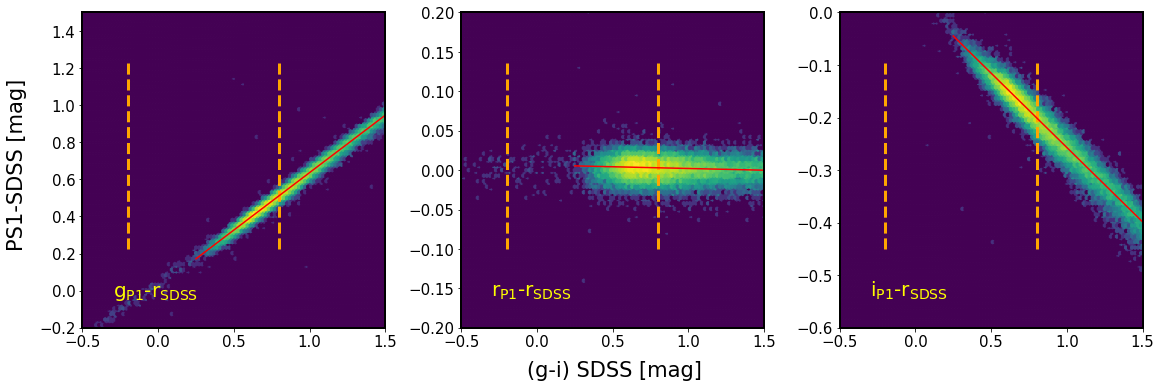

In [25]:
photometric_offset_sdss_ps1(data = s82_dr2_objid, sdsscolors = 'gi', targetbands = 'r',
                            originbands = 'gri',s82mag = 'med', s82err = 'msig',
                            cutoffmag = 19 , xlims = [-0.5,1.5] ,
                           correct_extinction = False ,ebv_sfd = None,
                            extinction = None, nrows = 1, ncols =3, 
                           )

In [26]:
off = Table.read('Offsets_PS1-SDSSr_SDSSgi_ext-NO.txt', format='ascii')

In [27]:
off

x,y,B_0,B_1
str10,str12,float64,float64
(g-i)_SDSS,g_P1-r_SDSS),0.017416816753023312,0.6194237568778429
(g-i)_SDSS,r_P1-r_SDSS),0.006487365361236326,-0.004383484507182645
(g-i)_SDSS,i_P1-r_SDSS),0.025998610050171803,-0.28303246532031046
